### Loading datasets

In [1]:
import torch
import numpy as np

from utils.dataset import MultiDataset
from utils.mask import tensor_arr_dist_circle_mask, tensor_img_dist_circle_mask 
from utils.optical_flow.spynet import spynet_optical_flow 
from utils.optical_flow.farneback import farneback_optical_flow
from utils.img_optic_vis import show_imgs, show_farneback_optical_flows, save_spynet_optical_flows

# Dataset and Loader
dataset_test = MultiDataset(
    ['data/same_vis_same_phys/train/sample_0/',
     'data/same_vis_same_phys/train/sample_1/',
     'data/same_vis_same_phys/train/sample_2/',
     'data/same_vis_same_phys/train/sample_3/'],
    img_size=(256, 256),
    buffer_size=3,
    random_order=True
    )

loader_train = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=4,  # we have modified data_parallel
    shuffle=False,  # we do not use this param
    drop_last=True,
    pin_memory=True)

# create loader iterator
iterator_train = iter(loader_train)

In [2]:
output = iterator_train.next()

## Testing images and optical flow

### Metres to pixel based masking

In [3]:
# px_per_m calculation
q = 55.0 * np.pi / 180
focal_length = 256.0 / np.tan(q/2)
px_per_m = focal_length * 1/2
m_per_px = 1 / px_per_m

In [4]:
# backtracking 256 px_per_m to q
focal_length = 2 * 256
q = np.arctan(256.0 / focal_length) * 2 * 180 / np.pi

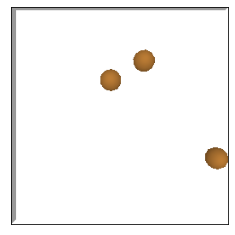

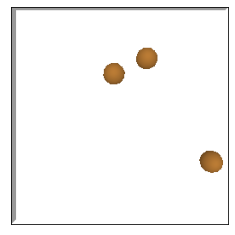

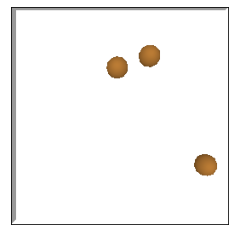

In [5]:
for i in range(len(output['img_data'][0])):
    show_imgs([output['img_data'][0, i]])

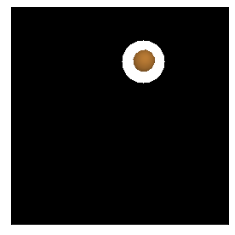

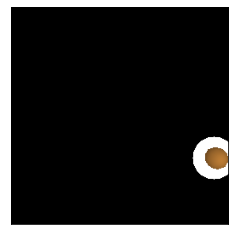

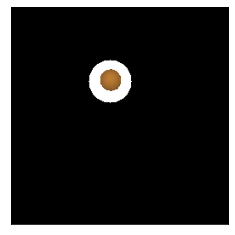

In [6]:
for cx,cy,cr in output['state_label'][0][0][:, [0,1,-1]].detach().numpy():
    show_imgs([tensor_img_dist_circle_mask(output['img_data'][0][0], cx, cy, cr + 0.05)])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


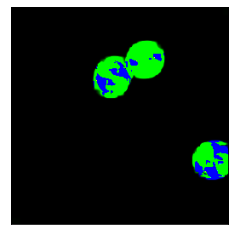

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


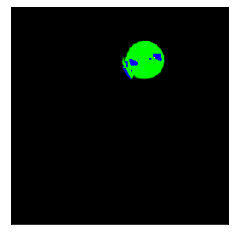

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


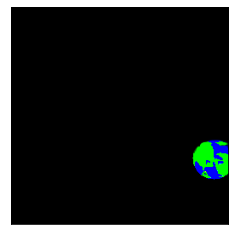

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


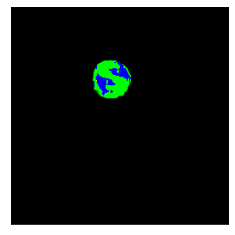

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


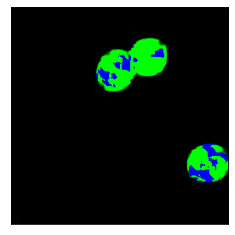

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


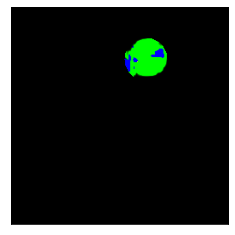

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


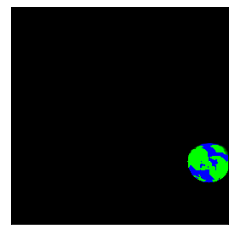

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


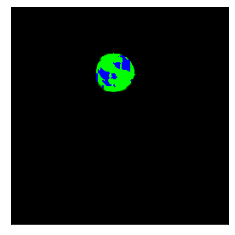

In [7]:
opt_flow_masks = []
cxs = []
cys = []
crs = []

for i in range(2):
    opt_flow = farneback_optical_flow(output['img_data'][0][i], output['img_data'][0][i+1])
    opt_flow_masks.append(opt_flow)
    
    for j in range(3):
        cx = output['state_label'][0][i][j, 0]
        cy = output['state_label'][0][i][j, 1]
        cr = output['state_label'][0][i][j, -1]
        
        cxs.append(cx)
        cys.append(cy)
        crs.append(cr)    
        opt_flow_masks.append(tensor_arr_dist_circle_mask(opt_flow, cx, cy, cr, 0.1))

for i in range(len(opt_flow_masks)):
    show_farneback_optical_flows([opt_flow_masks[i]])

In [8]:
opt_flow_masks = []
cxs = []
cys = []
crs = []

for i in range(2):
    opt_flow = spynet_optical_flow(output['img_data'][0][i], output['img_data'][0][i+1])
    opt_flow_masks.append(opt_flow)
    
    for j in range(3):
        cx = output['state_label'][0][i][j, 0]
        cy = output['state_label'][0][i][j, 1]
        cr = output['state_label'][0][i][j, -1]
        
        cxs.append(cx)
        cys.append(cy)
        crs.append(cr)    
        opt_flow_masks.append(tensor_arr_dist_circle_mask(opt_flow, cx, cy, cr, 0.1))

#save_spynet_optical_flows(opt_flow_masks)